# Week 5 notebook
> Gradient boosting

- toc: true 
- badges: true
- comments: true
- categories: [machine-learning, workshop, boosting-method, gradient-boosting, xgboost]


In [14]:
import numpy as np
import sklearn
import matplotlib.pyplot as plt

# Adaboost



In [69]:

def sample_one(probabilities):
    """
    Generate a single sample with probability density specified by
      `probabilities = [p1, p2, ..., pN]`
    We will return an index `i` between 0 and N-1 inclusive.
    """
    assert np.abs(np.sum(probabilities) - 1) < 0.0001 # just checking this is an honest probability density
    
    N = len(probabilities) # size of the sample space
    cummulative_density = np.cumsum(probabilities) # compute CDF
    cummulative_density = np.concatenate([[0], cummulative_density]) # prepend 0 to the list
    random_seed = np.random.rand() # generate a single random number between 0 and 1 uniformly.
    
    # Look for the index i such that CDF[i -1] <= random_seed <= CDF[i]
    for i in range(N):
        if cummulative_density[i] < random_seed <= cummulative_density[i + 1]:
            return i # break and return when found

def sample(n, items, probabilities):
    """For pedagogy only. Inefficient implementation"""
    samples = []
    for _ in range(n):
        index = sample_one(probabilities)
        samples.append(items[index])
    return samples


items = ['a', 'b', 'c', 'd']
probabilities = [1/8, 1/8, 4/8, 2/8]
num_samples = 10000
samples = sample(num_samples, items, probabilities)

print(f"Empirical probabilities:")
a, b = np.unique(samples,  return_counts=True)
for a, b in zip(*np.unique(samples,  return_counts=True)):
    print(f"Probability of oberving {a} = {b / num_samples}")

Empirical probabilities:
Probability of oberving a = 0.1258
Probability of oberving b = 0.1243
Probability of oberving c = 0.4931
Probability of oberving d = 0.2568


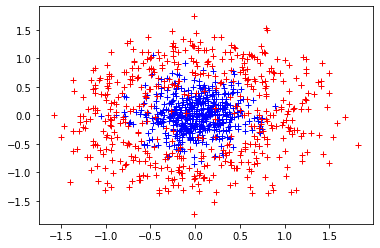

In [272]:
from sklearn.datasets import make_circles
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.ensemble import VotingClassifier

n = 1000
sigma = 0.3
factor = 0.1
X, y = make_circles(n_samples=n, noise=sigma, factor=factor)
y = (2 * y - 1).astype(int)

plt.plot(X[y == 1][:, 0], X[y == 1][:, 1], 'b+')
plt.plot(X[y == -1][:, 0], X[y == -1][:, 1], 'r+')

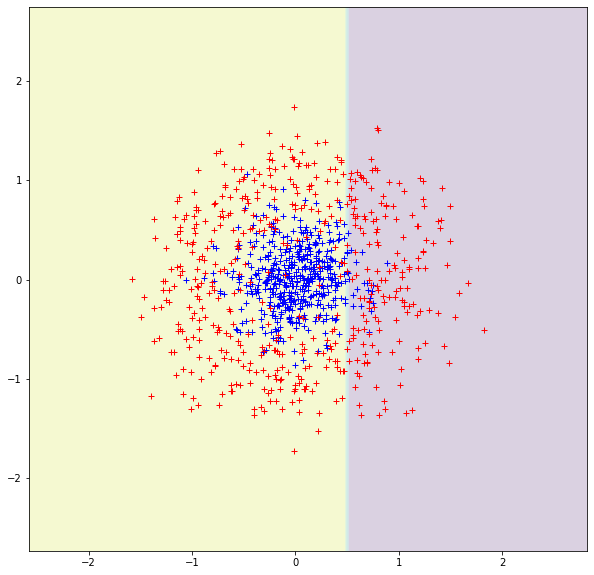

In [273]:
# clf = SVC(kernel="linear")
clf = DecisionTreeClassifier(max_depth=1)
clf.fit(X, y)
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
DecisionBoundaryDisplay.from_estimator(clf, X, alpha=0.2, response_method="predict", ax=ax)
ax.plot(X[y == 1][:, 0], X[y == 1][:, 1], 'b+')
ax.plot(X[y == -1][:, 0], X[y == -1][:, 1], 'r+')

In [274]:
classifiers = []
weights = np.ones(n) /  n
confidences = []
loss_fn = lambda f, x, y: np.exp(-y * f(x))
num_iter = 12
chosen = []


for t in range(num_iter):
    weights = weights / np.sum(weights)
#     clf = SVC(kernel="linear", C=1.0)
    clf = DecisionTreeClassifier(max_depth=1)

    indices = sample(n // 3, list(range(len(y))), weights)
    X_t = X[indices]
    y_t = y[indices]
    chosen.append(indices)
    clf.fit(X_t, y_t)
    classifiers.append(clf)
    
    pred = clf.predict(X)
    error = np.sum([weights[i] for i in range(n) if pred[i] != y[i]])
#     error = np.clip(np.sum(pred != y), a_min=0.01, a_max=0.99)
    conf = 1/2 * np.log((1 - error) / error)
    confidences.append(conf)
    weights = weights * np.exp(-(pred * y) * conf)

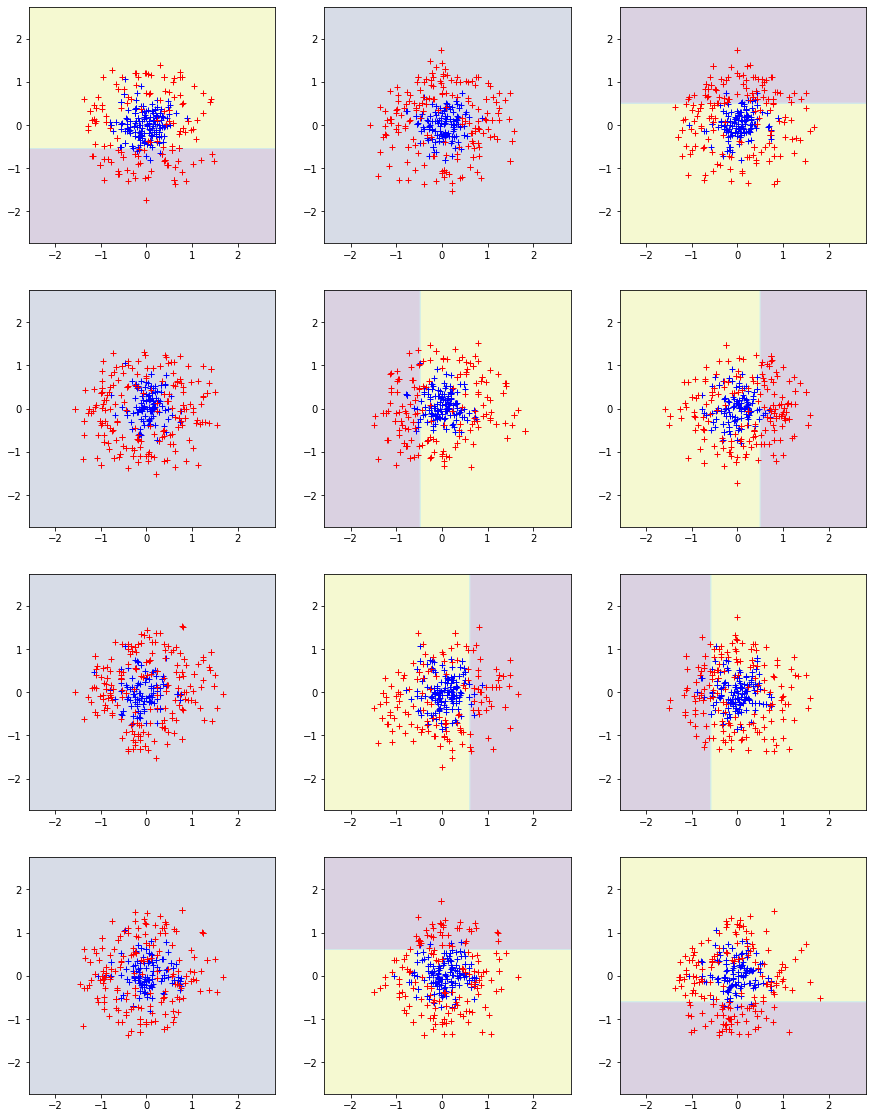

In [275]:
ncol = 3
nrow = num_iter // ncol + (num_iter % ncol)

fig, axes = plt.subplots(nrow, ncol, figsize=(5 * ncol, 5 * nrow))
axes = np.ravel(axes)
for i in range(num_iter):
    ax = axes[i]
    clf = classifiers[i]
    indices = chosen[i]
    ax.plot(X[indices][y[indices] == 1][:, 0], X[indices][y[indices] == 1][:, 1], 'b+')
    ax.plot(X[indices][y[indices] == -1][:, 0], X[indices][y[indices] == -1][:, 1], 'r+')
    DecisionBoundaryDisplay.from_estimator(clf, X, alpha=0.2, response_method="predict", ax=ax)

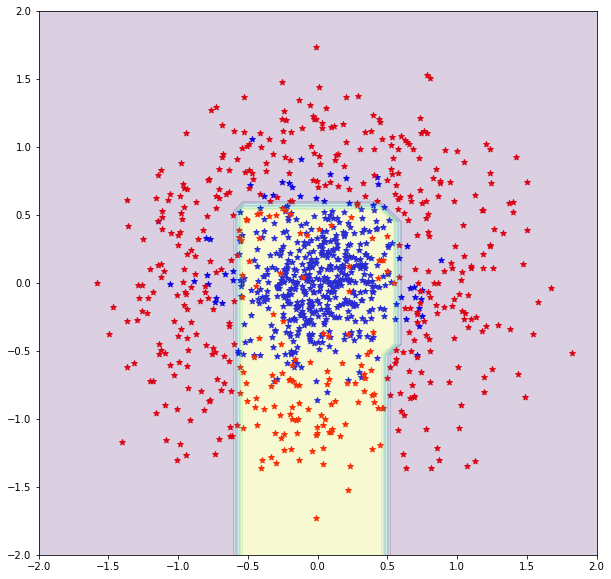

In [276]:
def pred(x):
    ps = np.array([clf.predict(np.array(x).reshape(1, -1)) for clf in classifiers])
    pos = np.sum(np.array(confidences) * (ps == 1))
    neg = np.sum(np.array(confidences) * (ps == 1))
    if pos > neg:
        return 1
    else:
        return -1


fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.scatter(
    X[y == 1][:, 0], 
    X[y == 1][:, 1], 
#     s=10 ** (weights[y == 1] * 100), 
    marker="*", 
    color="blue"
)

ax.scatter(
    X[y == -1][:, 0], 
    X[y == -1][:, 1], 
#     s=10 ** (weights[y == -1] * 100), 
    marker="*", 
    color="red"
)

a = np.linspace(-2, 2, num=50)
b = np.linspace(-2, 2, num=50)
ps = np.array([(x1, x2) for x1 in a for x2 in b])
preds = np.array([clf.predict(ps) for clf in classifiers]).T
preds = preds * np.array(confidences)
pos = np.sum(preds, axis=1)
neg = np.sum(-preds, axis=1)
Z = 2 * (pos > neg) - 1
Z = Z.reshape(50, 50)
XX, YY = np.meshgrid(a, b)
ax.contourf(XX, YY, Z, alpha=0.2)



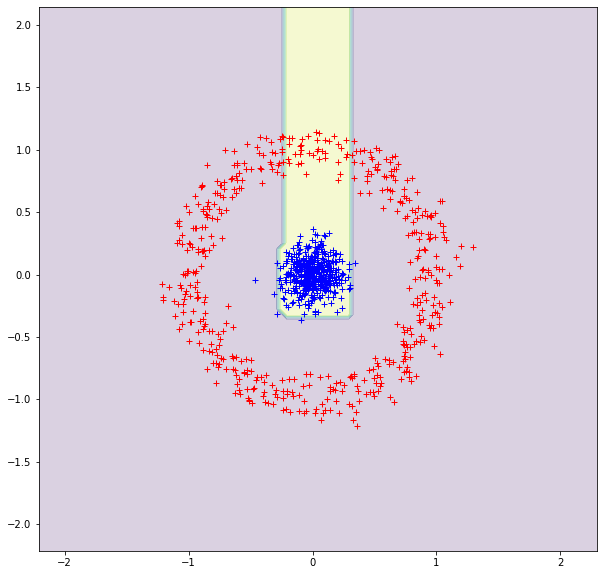

In [264]:
from sklearn.ensemble import AdaBoostClassifier

clf = AdaBoostClassifier(
#     base_estimator=SVC(kernel="linear"), 
    algorithm="SAMME", 
    n_estimators=10
)
clf.fit(X, y)
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

DecisionBoundaryDisplay.from_estimator(clf, X, alpha=0.2, response_method="predict", ax=ax)
ax.plot(X[y == 1][:, 0], X[y == 1][:, 1], 'b+')
ax.plot(X[y == -1][:, 0], X[y == -1][:, 1], 'r+')

# Bagging vs Boosting

|     | Bagging | Boosting | 
| --- | ----  | ----|
| **Sampling** | Uniformly at random. | Weighted based on performance from last iteration. |
| **Parallelisable?** | Can train learners in parallel | Learners training depend on previous iteration. |
| **Classification rule** | Majority vote | Weighted majority vote | 
| **Bias or Variance** | Focus on reducing variance | Focus on reducing bias | 
| **Prone to overfitting?** | Relatively safe from overfitting | Can overfit | 
| 